## Re-fit dynamical runs 

In [1]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [103]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 22044 # mid-length width at rim depth
Wr = 13756.1 # width at lid-length at shelf break isobath
Hh= 97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=147.5):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [104]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()

### Not all runs are used to fit the data and find the fitting constants:

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_step** has all runs in records_dyn plus the runs with a step Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_kv** has all runs with step Kv profile. Use this list to fit N below for step Kv runs.

**records_nokv** has all runs except the ones with step Kv profile. Use this list to fit N below.

In [105]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,28,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]

for ii in select_rec:
    print(ii,records[ii].label2)
    

0 base case
1 $\uparrow$ $K_{bg}$
2 $\uparrow \uparrow$ $K_{bg}$
3 $\uparrow$ $N_0$
4 $\uparrow \uparrow$ $N_0$
5 $\Downarrow$ $N_0$
51 $\downarrow \downarrow N_0$
6 $\downarrow$ $N_0$
7 $\uparrow f$
8 $\downarrow \downarrow$ $f$
9 $\downarrow f$
10 $\Downarrow f$
17 $\downarrow$ U
18 $\downarrow \downarrow$ U
19 $\Downarrow$ U
20 $\Downarrow$ U, $\downarrow \downarrow$ $N_0$
21 $\Downarrow$ U, $\uparrow \uparrow$ $N_0$
22 $\Downarrow$ U, $\Downarrow$ $f$
23 $\Downarrow$ U, $\uparrow \uparrow K_{can}$
24 $K_{can}$ Monterey (bot)
25 $K_{can}$ Eel (bot)
26 $K_{can}$ Monterey
27 $K_{can}$ Ascension (bot)
28 $K_{can}$ Ascension
29 $\Uparrow \Uparrow K_{can}$, $\epsilon 10$
30 $\Uparrow \Uparrow K_{can}$, $\epsilon 25$
31 $\Uparrow \Uparrow K_{can}$, $\epsilon 50$
32 $\Uparrow \Uparrow K_{can}$, $\epsilon 100$
33 $\Uparrow \Uparrow K_{can}$, $\epsilon 15$
34 $\Uparrow \Uparrow K_{can}$, $\epsilon 75$
35 $\Uparrow \Uparrow K_{can}$, $\epsilon 150$
38 $\uparrow \uparrow K_{can}$
39 $\Uparrow 

In [106]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27,28]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [107]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
    print(ind, records[ind].exp_code)

0 CNTDIFF
1 CNTDIFF
2 CNTDIFF
3 CNTDIFF
4 CNTDIFF
5 CNTDIFF
51 CNTDIFF
6 CNTDIFF
7 CNTDIFF
8 CNTDIFF
9 CNTDIFF
10 CNTDIFF
17 LOWER_BF
18 LOW_BF
19 LOWEST_BF
20 LOWEST_BF
21 LOWEST_BF
22 LOWEST_BF
23 LOWEST_BF
24 3DVISC_REALISTIC
25 3DVISC_REALISTIC
26 3DVISC_REALISTIC
27 3DVISC_REALISTIC
28 3DVISC_REALISTIC
29 3DVISC_REALISTIC
30 3DVISC_REALISTIC
31 3DVISC_REALISTIC
32 3DVISC_REALISTIC
33 3DVISC_REALISTIC
34 3DVISC_REALISTIC
35 3DVISC_REALISTIC
38 3DVISC_REALISTIC
39 3DVISC_REALISTIC
41 3DVISC_REALISTIC
42 3DVISC_REALISTIC
43 3DVISC_REALISTIC
44 3DVISC_REALISTIC
45 3DVISC_REALISTIC
46 3DVISC_REALISTIC
47 3DVISC_REALISTIC
48 3DVISC_REALISTIC
49 3DVISC_REALISTIC


In [108]:
keys2 = ['N_tt16','N_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean = Nmean + np.mean(df[keys2[ii]][20:24])
        Nrim = Nrim + df[keys2[ii]][24]
    records[ind].Nab_h = Nab/  len(keys2)
    records[ind].Nbe_h = Nbe/  len(keys2)

In [109]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'UwH' # Station at downstream side of canyon

for record in records_sel:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
 
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.inidTrdz = df[key0][30]
print('The initial tracer gradient is %f ' %(-1*record.inidTrdz))

The initial tracer gradient is nan 


In [110]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'UwH' # Station at downstream side of canyon

for record in records_sel:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
    maxd0 = df[key0][29]
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.TrSB = maxd0

Ctop = df[key0][0]

## Re-fit HA2013
(They may have had recirculation). First look at different W's. I need W, width at mid-length at rim depth and Ws, width at mid-length at shelf break isobath.

Width at rim depth at mid length is -22044.8 m
Width at sb depth at mid length is -13756.1 m
rim depth at mid length is 131.3 m
shelf break depth is 149.8 m
head depth is 98.8 m
Big L is 8332.6 m
L is 6400.5 m


(47000, 65000)

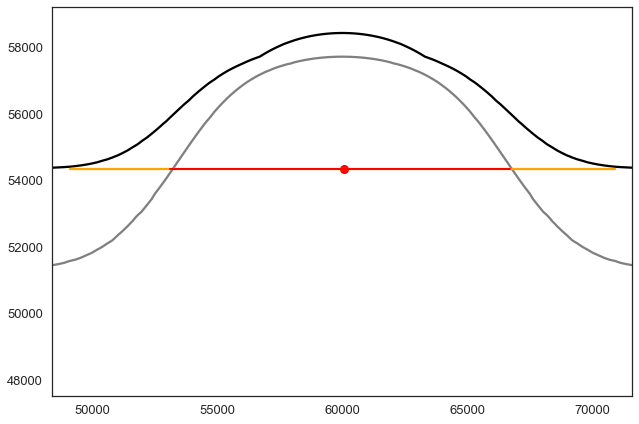

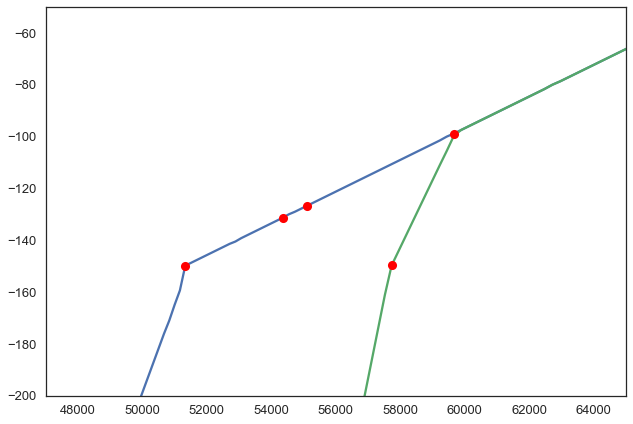

In [112]:
sb_ind = 29
length = 6000

depth = CanyonGridOut.variables['Depth'][:]
Y = CanyonGridOut.variables['Y'][:]
X = CanyonGridOut.variables['X'][:]
RC = CanyonGridOut.variables['RC'][:]
 
fig, ax = plt.subplots(1,1)
ax.contour(X[110:250],Y[200:267],depth[200:267,110:250], levels=[131.3, 149.8], colors=['k','0.5'])
ax.plot(X[180],Y[242],'or')
ax.plot(X[113:247],np.ones(len(X[113:247]))*Y[242],'-', color='orange')
ax.plot(X[133:226],np.ones(len(X[133:226]))*Y[242],'-r', linewidth=2)

fig, ax = plt.subplots(1,1)
ax.plot(Y,-depth[:,300])
ax.plot(Y,-depth[:,180])
ax.plot(Y[225],-depth[225,300],'ro')
ax.plot(Y[268],-depth[268,300],'ro')
ax.plot(Y[246],-depth[246,300],'ro')
ax.plot(Y[259],-depth[259,180],'ro')
ax.plot(Y[242],-depth[242,300],'ro')

print('Width at rim depth at mid length is %1.1f m' %(X[113]-X[247]))
print('Width at sb depth at mid length is %1.1f m' %(X[133]-X[226]))

print('rim depth at mid length is %1.1f m' %depth[242,300])
print('shelf break depth is %1.1f m' %depth[225,300])
print('head depth is %1.1f m' %depth[268,300])

print('Big L is %1.1f m' %(Y[268]-Y[225]))
print('L is %1.1f m' %(Y[259]-Y[225]))


ax.set_ylim(-200,-50)
ax.set_xlim(47000,65000)


In [113]:
# records_dyn has all runs where Kv does not change, only N, f, U

for param in np.linspace(0.8, 1.2, 30):
    for rec in records_dyn:

        Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,Wr))/Ro(rec.u_mod,rec.f,L))**(1/2)))
        rec.X = (F(Ro(rec.u_mod,rec.f,Wr))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3)

        can_eff = rec.HCW
        Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
        Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
        
        rec.Phi = Phi
        rec.Phi_std = Phi_std
        rec.Phi_nonDim = rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N))

    Y_array = np.array([rec.Phi_nonDim for rec in records_dyn])
    X_array = np.array([rec.X for rec in records_dyn])

    slope0, intercept0, r_value0, p_value0, std_err0 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope0, intercept0, r_value0))

Using parameter 0.80: slope = 2.37, intercept = -0.006, r-value = 0.971
Using parameter 0.81: slope = 2.44, intercept = -0.006, r-value = 0.974
Using parameter 0.83: slope = 2.50, intercept = -0.006, r-value = 0.976
Using parameter 0.84: slope = 2.57, intercept = -0.005, r-value = 0.978
Using parameter 0.86: slope = 2.63, intercept = -0.005, r-value = 0.979
Using parameter 0.87: slope = 2.69, intercept = -0.005, r-value = 0.980
Using parameter 0.88: slope = 2.75, intercept = -0.004, r-value = 0.980
Using parameter 0.90: slope = 2.81, intercept = -0.004, r-value = 0.980
Using parameter 0.91: slope = 2.87, intercept = -0.003, r-value = 0.979
Using parameter 0.92: slope = 2.93, intercept = -0.003, r-value = 0.978
Using parameter 0.94: slope = 2.99, intercept = -0.002, r-value = 0.976
Using parameter 0.95: slope = 3.05, intercept = -0.002, r-value = 0.975
Using parameter 0.97: slope = 3.11, intercept = -0.001, r-value = 0.972
Using parameter 0.98: slope = 3.17, intercept = -0.000, r-value 

I got the largest r-value (0.980) for parameter values 0.87 to 0.90.  

In [114]:
param = 0.89

for rec in records_dyn:

    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,Wr))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    rec.X = (F(Ro(rec.u_mod,rec.f,Wr))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3)

    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    rec.Phi = Phi
    rec.Phi_std = Phi_std
    rec.Phi_nonDim = rec.Phi/(rec.u_mod*W*Dh(rec.f,L,rec.N))

Y_array = np.array([rec.Phi_nonDim for rec in records_dyn])
X_array = np.array([rec.X for rec in records_dyn])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_array,Y_array)
print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope, intercept, r_value))

Using parameter 0.89: slope = 2.78, intercept = -0.004, r-value = 0.980


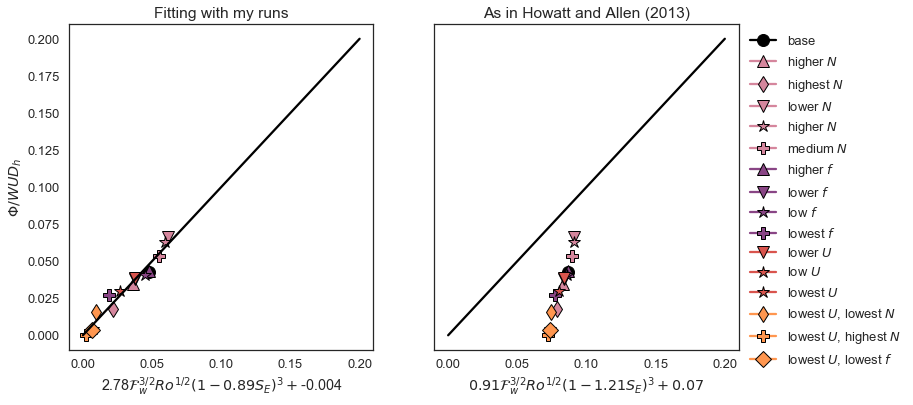

In [115]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)

for rec in records_dyn:
    
    ax1.plot(slope*rec.X+intercept,rec.Phi_nonDim, 
             marker = rec.mstyle,markersize = 12,
             color = sns.xkcd_rgb[rec.color2],
             markeredgewidth=1.0,
             markeredgecolor = 'k',
             label=rec.label)
    
    ax2.plot(0.91*rec.X+0.07,rec.Phi_nonDim, 
             marker = rec.mstyle,markersize = 12,
             color = sns.xkcd_rgb[rec.color2],
             markeredgewidth=1.0,
             markeredgecolor = 'k',
             label=rec.label)

xx = np.linspace(0,0.2,50)
ax1.plot(xx,xx,'k-')
ax2.plot(xx,xx,'k-')

ax1.set_ylabel('$\Phi/WUD_h$')
ax1.set_xlabel(r'%1.2f$\mathcal{F}_w^{3/2}Ro^{1/2}(1-%1.2f S_E)^3+$%1.3f' %(slope,param, intercept))
ax2.set_xlabel(r'$0.91\mathcal{F}_w^{3/2}Ro^{1/2}(1-1.21S_E)^3+0.07$')

ax1.set_title('Fitting with my runs')
ax2.set_title(r'As in Howatt and Allen (2013)')

ax2.legend(bbox_to_anchor=(1.0,1),ncol=1, columnspacing=0.1)

#### So, the modified scaling for upwelling flux $\Phi$ is: $$2.78\mathcal{F}_w^{3/2}Ro^{1/2}(1-0.89S_E)^3-0.004$$